# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4
# Load a random seed so the test is repeatable
np.random.seed(90)

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 3]
 [0 2 0 0]
 [0 0 0 0]
 [0 0 0 1]]
check?  0
dofk2  0

[[0 0 0 3]
 [0 2 0 0]
 [0 0 0 0]
 [0 0 1 0]]
0.0  1
check?  0
dofk2  0


In [4]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))

Random_Agent, Average reward: 0.18 Number of steps:  6.814


In [5]:
def EpGreedPol(Q, epsilon, allowed_a):
    allowed_act = np.where(allowed_a == 1)[0]
    allowed_Q = Q[allowed_act]

    rand_values = np.random.uniform(0, 1)

    if rand_values < epsilon:
        a = np.random.choice(allowed_act)
    else:
        max_Q = np.argmax(allowed_Q)
        a = allowed_act[max_Q]

    return a

In [6]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 

#Initialize the neural network with random weights and biases
def initialize_NN(N_in, N_h, N_a):
    W1 = np.random.rand(N_h, N_in)
    b1 = np.random.rand(N_h, 1)
    W2 = np.random.rand(N_a, N_h)
    b2 = np.random.rand(N_a, 1)
    return W1, b1, W2, b2
#Carry out forward propagation in the NN 
def forward_prop(X, W1, b1, W2, b2):
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = Z2
    return Z1, A1, Z2, A2
#Carry out backward propagation in the NN
def backward_prop(X, Y, Z1, A1, Z2, A2, W1, W2):
    m = X.shape[1]

    dZ2 = 2 * (A2 - Y) / m
    dW2 = np.dot(dZ2, A1.T)
    db2 = np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = relu_backward(dA1, Z1)
    dW1 = np.dot(dZ1, X.T)
    db1 = np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2
#Update weights/ bias parameters using gradients and learning rate
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, eta):
    W1 -= eta * dW1
    b1 -= eta * db1
    W2 -= eta * dW2
    b2 -= eta * db2
    return W1, b1, W2, b2

# Relu activation function
def relu(Z):
    return np.maximum(0, Z)
#Gradient of Relu
def relu_backward(dA, Z):
    dZ = dA * (Z > 0)
    return dZ
#Initialise game
S, X, allowed_a = env.Initialise_game()
N_a = np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in = np.shape(X)[0]    ## INPUT SIZE
N_h = 200                ## NUMBER OF HIDDEN NODES

## INITALISE YOUR NEURAL NETWORK...
W1, b1, W2, b2 = initialize_NN(N_in, N_h, N_a)

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])

In [7]:
#Training loop
for n in range(N_episodes):
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        #Forward prop for Q-values
        _, _, _, Qvaluesall = forward_prop(X.reshape(N_in, 1), W1, b1, W2, b2)
        #Call epislon greedy to make an action
        a_agent = EpGreedPol(Qvaluesall, epsilon_f, allowed_a)
        #Execute action and look at the next state, reward this action and then flag it as done
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a_agent)

        if Done==1:
            #Terminate episode and save number of moves
            R_save[n] = np.copy(R)
            N_moves_save[n] = np.copy(i)
            #Update QValue for action using reward
            Qvaluesall[a_agent] = R
            #Call back prop to update parameters
            dW1, db1, dW2, db2 = backward_prop(X.reshape(N_in, 1), Qvaluesall, *forward_prop(X.reshape(N_in, 1), W1, b1, W2, b2), W1, W2)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, eta)
            break
        else:
            #Forward Prop for the next state
            _, _, _, Qvaluesall_next = forward_prop(X_next.reshape(N_in, 1), W1, b1, W2, b2)
            #Run on greedy policy where epislon = 0
            a_agent_next = EpGreedPol(Qvaluesall_next, 0, allowed_a_next)
            #Update QValue by action observed reward and discounted Qvalue of next action
            Qvaluesall[a_agent] = R + gamma * Qvaluesall_next[a_agent_next]
            #backprop and update params
            dW1, db1, dW2, db2 = backward_prop(X.reshape(N_in, 1), Qvaluesall, *forward_prop(X.reshape(N_in, 1), W1, b1, W2, b2), W1, W2)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, eta)

        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    if n % 200 == 0:
        print(f"{n} Epochs Complete - Reward: {R_save[n]} - Number of Moves: {N_moves_save[n]}")

0 Epochs Complete - Reward: [0.] - Number of Moves: [1.]
200 Epochs Complete - Reward: [0.] - Number of Moves: [1.]
400 Epochs Complete - Reward: [0.] - Number of Moves: [30.]
600 Epochs Complete - Reward: [0.] - Number of Moves: [17.]
800 Epochs Complete - Reward: [0.] - Number of Moves: [3.]
1000 Epochs Complete - Reward: [1.] - Number of Moves: [28.]
1200 Epochs Complete - Reward: [1.] - Number of Moves: [11.]
1400 Epochs Complete - Reward: [0.] - Number of Moves: [1.]
1600 Epochs Complete - Reward: [0.] - Number of Moves: [26.]
1800 Epochs Complete - Reward: [0.] - Number of Moves: [5.]
2000 Epochs Complete - Reward: [0.] - Number of Moves: [4.]
2200 Epochs Complete - Reward: [0.] - Number of Moves: [34.]
2400 Epochs Complete - Reward: [0.] - Number of Moves: [77.]
2600 Epochs Complete - Reward: [1.] - Number of Moves: [12.]
2800 Epochs Complete - Reward: [0.] - Number of Moves: [11.]
3000 Epochs Complete - Reward: [1.] - Number of Moves: [21.]
3200 Epochs Complete - Reward: [1.] -

Final Reward per Game: 0.6383735047718565
Final Number of Moves per Game: 13.642490015189722
Average Reward per Game: 0.57959
Average Number of Moves per Game: 11.34915


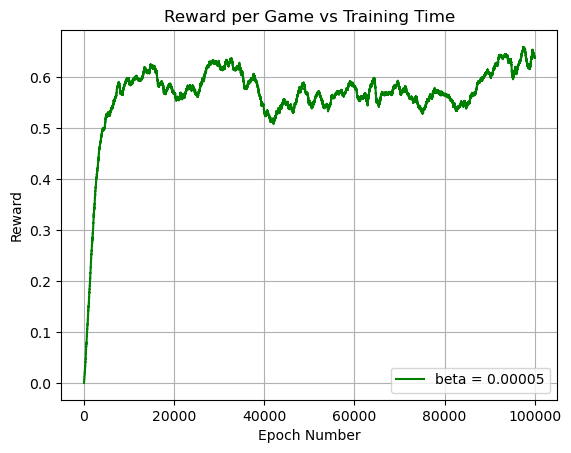

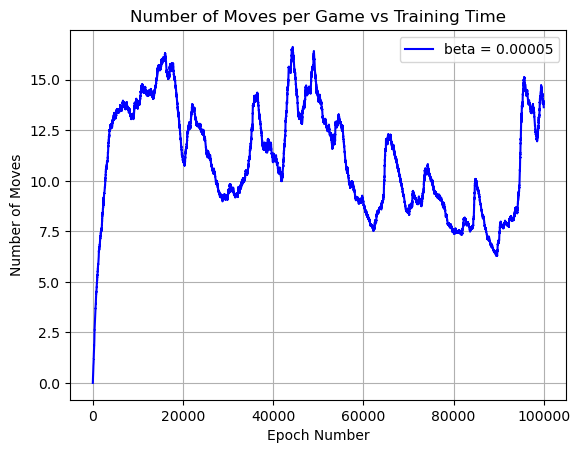

In [8]:
#Exponential Moving Average function required for plots
def ExpMoveingAvg(Y, B):
    Y = np.asarray(Y)
    ExpMoveingAvgY = np.zeros(Y.shape)
    y = 0

    for i in range(len(Y)):
        y = B * y + (1 - B) * Y[i]
        ExpMoveingAvgY[i] = y

    return ExpMoveingAvgY.tolist()
#Calculate Exponential Moving Average using function above
ExpMoveingAvg_rewards = ExpMoveingAvg(R_save[:, 0], 0.9995)
ExpMoveingAvg_moves = ExpMoveingAvg(N_moves_save[:, 0], 0.9995)
#Print statements to show progress
print(f"Final Reward per Game: {ExpMoveingAvg_rewards[-1]}")
print(f"Final Number of Moves per Game: {ExpMoveingAvg_moves[-1]}")
print(f"Average Reward per Game: {np.mean(R_save)}")
print(f"Average Number of Moves per Game: {np.mean(N_moves_save)}")

#Printing first plot showing reward vs training time
plt.figure()
plt.title("Reward per Game vs Training Time")
plt.plot(ExpMoveingAvg_rewards, color='green', label="beta = 0.00005")
plt.xlabel('Epoch Number')
plt.ylabel('Reward')
plt.legend()
plt.grid()
plt.show()

#Plotting of the number of moves per game vs training time
plt.figure()
plt.title("Number of Moves per Game vs Training Time")
plt.plot(ExpMoveingAvg_moves, color='blue', label="beta = 0.00005")
plt.xlabel('Epoch Number')
plt.ylabel('Number of Moves')
plt.legend()
plt.grid()
plt.show()